In [34]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns

from importlib.resources import files

sns.set()

DATA_DIR = files("biobank_olink.data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
results = [json.load(p.open()) for p in (DATA_DIR / "../../results").iterdir()]
results = pd.DataFrame(chain.from_iterable(results))
results.loc[results.model.isnull(), "model"] = "xgb"
results["target"] = results.target.str.upper()

targets = ["SBP", "DBP", "PP"]
panels = ["all"]#, "cardiometabolic", "inflammation"]

results_base = results.loc[results.interactions.isin((0, np.nan, None)) & results.n_best_feats.isin((0, np.nan, None))]

In [50]:
results_lr = results_base.loc[results_base.model == "lr"]
agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "num_trials", "best_trial_no", "tol"]}
results_lr.groupby(["model", "panel", "target"]).agg(**agg_values, count=("model", 'size'))

mean_auc_score  mean_num_trials  mean_best_trial_no  \
model panel target                                                        
lr    all   DBP           0.802330           1003.0               109.4   
            PP            0.734952           1003.0                88.2   
            SBP           0.813886           1002.4               186.6   

                    mean_tol  count  
model panel target                   
lr    all   DBP     0.086924      5  
            PP      0.068405      5  
            SBP     0.070602      5

In [37]:
results_xgb = results_base.loc[results_base.model == "xgb"]
results_xgb.loc[:, "feat_importance"] = results_xgb.feat_importance.apply(
    lambda x: x[0] if isinstance(x, list) else x)
agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "num_trials", "best_trial_no", "n_estimators"]}
results_xgb.groupby(["model", "panel", "target"]).agg(**agg_values, count=("model", 'size'))

mean_auc_score  mean_num_trials  mean_best_trial_no  \
model panel target                                                        
xgb   all   DBP           0.797268           1003.0               572.4   
            PP            0.722441            506.8               400.4   
            SBP           0.802056           1007.0               506.6   

                    mean_n_estimators  count  
model panel target                            
xgb   all   DBP                2657.8      5  
            PP                 2469.2      5  
            SBP                2662.4      5

In [38]:
res_xgb_gb = results_xgb.groupby(["model", "panel", "target"]).agg(**agg_values,
                                                                   count=("model", 'size'))
res_lr_gb = results_lr.groupby(["model", "panel", "target"]).agg(**agg_values,
                                                                 count=("model", 'size'))
res = pd.concat([res_lr_gb, res_xgb_gb])
res["mean_auc_score"].unstack("target").reorder_levels([1, 0]).sort_index().loc[:, targets]

target            SBP       DBP        PP
panel model                              
all   lr     0.813886  0.802330  0.734952
      xgb    0.802056  0.797268  0.722441

/home/prenc/.miniconda3/envs/biobank_olink/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


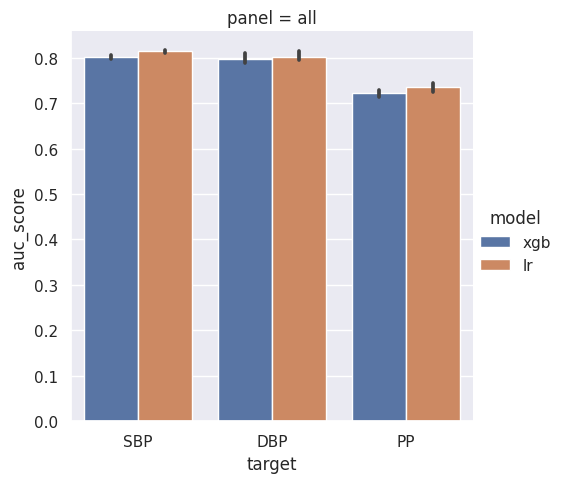

In [39]:
sns.catplot(data=pd.concat([results_xgb, results_lr]), x="target", y="auc_score",
            order=targets, hue="model", col="panel", kind="bar", col_order=panels)

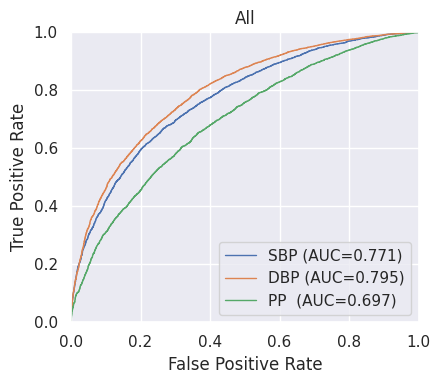

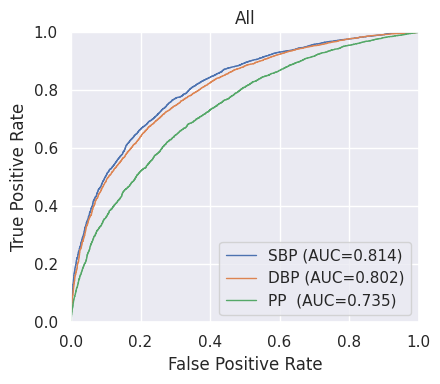

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def plot_auc_curve_by_panels(results, panels):
    plt.figure(figsize=(12, 4))
    for i, panel in enumerate(panels, 1):
        plt.subplot(1, 3, i)
        plt.xlim([0, 1.0])
        plt.ylim([0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(panel.title())

        for target in targets:
            single_case = results.loc[(results.target == target) & (results.panel == panel)]
            y_test, y_prob = single_case["y_test"].values, single_case["y_proba"].values
            y_test, y_prob = np.concatenate(y_test), np.concatenate(y_prob)

            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label=f"{target:<3} (AUC={auc_score:.3f})")

        plt.legend(loc='lower right')

    plt.tight_layout()


plot_auc_curve_by_panels(results_xgb, panels)
plt.show()
plot_auc_curve_by_panels(results_lr, panels)

## AUC p-value

In [41]:
from scipy.stats import norm
import math
from random import choices
from sklearn.metrics import roc_auc_score


def get_mean_and_std(results, target, panel, n):
    single_case = results.loc[(results.target == target) & (results.panel == panel)]
    y_test, y_prob = single_case["y_test"].values, single_case["y_proba"].values
    y_test, y_prob = np.concatenate(y_test), np.concatenate(y_prob)
    mean = roc_auc_score(y_test, y_prob)

    y_pairs = list(zip(y_test, y_prob))
    std = np.std([
        roc_auc_score(*list(zip(*choices(y_pairs, k=len(y_pairs)))))
        for _ in range(n)
    ])
    return mean, std, len(y_pairs)


def z_test(mu_X, sigma_X, n_X, mu_Y, sigma_Y, n_Y):
    Z = (mu_X - mu_Y) / math.sqrt((sigma_X ** 2 / n_X) + (sigma_Y ** 2 / n_Y))
    return 2 * norm.sf(abs(Z))


n = 100

pvals = []
for panel in panels:
    for target in targets:
        lr_mean, lr_std, lr_n = get_mean_and_std(results_lr, target, panel, n)
        xgb_mean, xgb_std, xgb_n = get_mean_and_std(results_xgb, target, panel, n)
        p_val = z_test(lr_mean, lr_std, lr_n, xgb_mean, xgb_std, xgb_n)
        pvals.append((panel, target, p_val))
xgb_vs_lr_pval = pd.DataFrame(pvals, columns=["panel", "target", "p_val"])
xgb_vs_lr_pval.pivot(index="target", columns="panel", values="p_val")

panel,all
target,
DBP,0.0
PP,0.0
SBP,0.0


## Feature importances

In [42]:
feat_imps = results_xgb.loc[
    (results_xgb.target == "SBP") & (results_xgb.panel == "all")].feat_importance
feat_imps = pd.DataFrame(list(feat_imps.values)).T.sort_values(0, ascending=False)
feat_imps.rank(ascending=False).astype(int)

,0,1,2,3,4
ERBB2,1,14,1,5,7
REN,2,6,4,7,2
NADK,3,3,2,22,5
GGT1,4,1,7,15,22
PIK3IP1,5,21,11,16,10
...,...,...,...,...,...
HAO1,1351,368,1171,806,1068
IL18BP,1352,1200,1351,1095,712
NCR1,1353,754,264,232,898
PLIN3,1354,603,1121,369,1250


In [47]:
from biobank_olink.dataset import load_olink_and_covariates

ol_df, _ = load_olink_and_covariates(cols_na_th=0.3, rows_na_th=0.3)
ol_df_corr = ol_df.corr()

[Memory]0.0s, 0.0min    : Loading load_olink_and_covariates...


In [53]:
from biobank_olink.dataset import get_olink_panel_mapping

corr_th = 0.5
mask = np.triu(np.ones(ol_df_corr.shape), k=1).astype(bool)
high_corr = ol_df_corr.where(mask)
correlated_cols = {column: dict(zip(high_corr.columns[high_corr[column] > corr_th].tolist(),
                                    high_corr[column][high_corr[column] > corr_th].tolist()))
                   for column in high_corr.columns}

assays_mapping = get_olink_panel_mapping()


def olink_to_panels(olink):
    return [
        panel
        for panel, olinks in assays_mapping.items()
        if olink in olinks
    ]


def get_feat_imps(res, panel):
    feat_imps = (
        res.loc[(res.panel == panel)]
        .groupby("target").feat_importance
        .apply(lambda x: pd.DataFrame(x.values.tolist()).mean().sort_values(ascending=False))
        .unstack("target")
    )
    present_targets = [col for col in targets if col in feat_imps.columns]
    feat_imps = feat_imps[present_targets]
    feat_ranks = feat_imps.rank(ascending=False)
    feat_ranks.columns = [f"{col}_rank" for col in feat_ranks.columns]
    feat_imps = pd.concat([feat_imps, feat_ranks], axis=1)
    feat_imps = feat_imps[[f"{col}{suffix}" for col in present_targets for suffix in ["", "_rank"]]]
    return feat_imps


feat_imps = get_feat_imps(results_lr, "all")
feat_imps["panel"] = feat_imps.index.map(olink_to_panels)
feat_imps[f"correlates_with (corr>{corr_th})"] = feat_imps.index.map(correlated_cols)
feat_imps.sort_values("SBP", ascending=False)

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank,panel,correlates_with (corr>0.5)
REN,0.014667,1.0,0.015950,1.0,0.008361,1.0,[Cardiometabolic],{}
ACTA2,0.004993,2.0,0.004318,4.0,0.004034,3.0,[Cardiometabolic],{}
CHGB,0.004915,3.0,0.003370,10.0,0.005612,2.0,[Neurology],{}
CRIP2,0.004667,4.0,0.004983,2.0,0.003942,4.0,[Neurology],{}
VWC2,0.004372,5.0,0.003538,9.0,0.002903,15.0,[Neurology],"{'BTN2A1': 0.5286438614083735, 'CKAP4': 0.5046..."
...,...,...,...,...,...,...,...,...
CLEC1B,0.000095,1351.0,0.000405,887.0,0.000250,1205.0,[Neurology],"{'ABHD14B': 0.5945902297163085, 'ABL1': 0.7449..."
ZBTB16,0.000070,1352.0,0.001157,226.0,0.001161,210.0,[Oncology],"{'ABHD14B': 0.519178045689597, 'ABL1': 0.78765..."
ALDH1A1,0.000069,1353.0,0.000211,1260.0,0.000312,1096.0,[Neurology],"{'AARSD1': 0.5618998054419375, 'ACY1': 0.54252..."
PSMA1,0.000067,1354.0,0.000895,353.0,0.000297,1134.0,[Oncology],{}


In [52]:
# export feature importances
exp_cases = results_base[["study_name", "target", "panel"]].drop_duplicates()

feat_importances_dir = DATA_DIR / "feat_importances"
feat_importances_dir.mkdir(exist_ok=True)
for _, (study_name, target, panel) in exp_cases.iterrows():
    feat_imps = results.loc[
        (results.study_name == study_name) &
        (results.target == target) &
        (results.panel == panel)
        ].feat_importance

    feat_imps = feat_imps.apply(lambda x: x[0] if isinstance(x, list) else x)
    feat_imps = pd.DataFrame(feat_imps.tolist()).mean().reset_index()
    feat_imps.columns = ["feature", "importance"]
    feat_imps.to_csv(feat_importances_dir / f"{study_name}.csv", index=False)

## LogisticRegressions - interactions

In [175]:
res_inter = results.loc[results.interactions > 0]
res_inter.groupby(["model", "panel", "target"]).agg(**agg_values, count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model panel           target                                    
lr    all             DBP           0.795019            214.8   
                      PP            0.714323            772.0   
                      SBP           0.803500            730.6   
      cardiometabolic DBP           0.753617            292.0   
                      PP            0.666726            624.8   
                      SBP           0.758168            650.0   
      inflammation    DBP           0.686795            731.0   
                      PP            0.627629           1043.6   
                      SBP           0.689192            537.8   

                              mean_best_trial_no  mean_n_estimators  count  
model panel           target                                                
lr    all             DBP                  170.0                NaN      5  
                      PP                   197.8                NaN      5  
                      SBP                  372.8                NaN      5  
      cardiometabolic DBP                  107.4                NaN      5  
                      PP                   483.2                NaN      5  
                      SBP                  228.4                NaN      5  
      inflammation    DBP                  438.4                NaN      5  
                      PP                   577.8                NaN      5  
                      SBP                  190.0                NaN      5

In [176]:
get_feat_imps(res_inter, "all").sort_values("SBP", ascending=False)

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.046747,1.0,0.048907,1.0,0.031770,1.0
CHGB,0.014414,2.0,0.010343,5.0,0.021168,2.0
ACTA2,0.013104,3.0,0.009918,7.0,0.012468,7.0
EFNA1,0.010540,4.0,0.004884,31.0,0.017795,3.0
VWC2,0.010162,5.0,0.007309,17.0,0.006705,20.0
...,...,...,...,...,...,...
VWC2*TGFBR3,NaN,NaN,NaN,NaN,0.000226,692.0
VWC2*TMPRSS15,NaN,NaN,0.000261,648.0,NaN,NaN
VWC2*TNFRSF13B,NaN,NaN,NaN,NaN,0.000039,1148.0
VWC2*TNFRSF19,NaN,NaN,0.000000,3983.0,NaN,NaN


## N best features

In [373]:
res_n_best = results.loc[results.n_best_feats.notna()]
res_n_best.groupby(["model", "panel", "target", "n_best_feats"]).agg(**agg_values,
                                                                     count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model panel target n_best_feats                                    
lr    all   DBP    200.0               0.780377            227.2   
                   500.0               0.791994            207.2   
            PP     200.0               0.709120            226.2   
                   500.0               0.724223            205.8   
            SBP    200.0               0.776875            226.8   
                   500.0               0.796892            206.0   

                                 mean_best_trial_no  mean_reg_alpha  count  
model panel target n_best_feats                                             
lr    all   DBP    200.0                       85.6             NaN      5  
                   500.0                       74.6             NaN      5  
            PP     200.0                       56.2             NaN      5  
                   500.0                       46.6             NaN      5  
            SBP    200.0                       63.6             NaN      5  
                   500.0                       96.4             NaN      5

In [377]:
feat_imps_n_best200 = get_feat_imps(res_n_best.loc[res_n_best.n_best_feats == 200],
                                    "all").sort_values("SBP", ascending=False)
feat_imps_n_best200

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.053249,1.0,0.055465,1.0,0.034907,1.0
NTRK3,0.016559,2.0,0.016539,3.0,0.008334,28.0
SPINK6,0.016470,3.0,0.014761,7.0,0.014470,8.0
LDLR,0.015345,4.0,0.007389,42.0,NaN,NaN
CRIP2,0.014823,5.0,0.017034,2.0,0.017069,5.0
...,...,...,...,...,...,...
TNFRSF9,NaN,NaN,NaN,NaN,0.007023,40.0
TNFSF10,NaN,NaN,NaN,NaN,0.001617,166.0
TRAF2,NaN,NaN,NaN,NaN,0.004408,88.0
TSHB,NaN,NaN,0.009303,24.0,NaN,NaN


In [379]:
feat_imps_n_best500 = get_feat_imps(res_n_best.loc[res_n_best.n_best_feats == 500],
                                    "all").sort_values("SBP", ascending=False)
feat_imps_n_best500

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.031186,1.0,0.033767,1.0,0.018394,1.0
CHGB,0.011459,2.0,0.008744,5.0,0.013755,2.0
ACTA2,0.010796,3.0,0.008771,4.0,0.007913,5.0
CRIP2,0.008242,4.0,0.010294,2.0,0.007889,6.0
EFNA1,0.008216,5.0,NaN,NaN,0.010229,3.0
...,...,...,...,...,...,...
UXS1,NaN,NaN,NaN,NaN,0.001989,188.0
VSIG4,NaN,NaN,NaN,NaN,0.001965,190.0
WAS,NaN,NaN,0.000904,369.0,NaN,NaN
WFDC2,NaN,NaN,NaN,NaN,0.003842,51.0


In [385]:
n = 10
len(feat_imps_n_best500.index[:n].intersection(feat_imps_n_best200.index[:n])) / n

0.6